In [1]:
import tensorflow as tf
import json
import os
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

dataset_folder = "./text_dataset/"
sensitive_datafile = "SensitiveDataset.json"
nonsensitive_datafile = "NonSensitiveDataset.json"

In [2]:
vocab_size = 3000
embedding_dim = 32
max_length = 60
truncation_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
dataList = []
sentences = []
labels = []
# Stopwords should be removed or excluded from the given text so that more 
# focus can be given to those words which define the meaning of the text.
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  with open(dataset_folder + filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    for word in stopwords: #Remove stop words in sentence
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    dataList.append([sentence, label])

# Loading both sensitive and non-sensitive dataset
loadDataset(sensitive_datafile)
loadDataset(nonsensitive_datafile)

# Shuffling the dataset randomly
random.shuffle(dataList)

# Dataset size: 31500 (approx)
print("Dataset Size: ", len(dataList))

# Dataset has both sentences and labels
for item in dataList:
  sentences.append(item[0])
  labels.append(item[1])

# Splitting up the total dataset
# Training size = 20000
# Validation size = 11500 (approx)
training_sentences = sentences[0:training_size]
validation_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
validation_labels = labels[training_size:]

print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences[0])
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:", validation_sentences[0])

Dataset Size:  31576
Training Dataset Size:  20000
Sample Training Data: Craig Jones, young man living South Central Los Angeles, just lost job framed stealing day off. Not plans, hangs front porch best friend, Smokey, carefree, mischievous drug dealer sells weed Big Worm, psychopathic neighborhood supplier.
Throughout day, Craig Smokey observe goings-on neighborhood. They encounter Ezail, supports drug habit petty crime; Debbie, attractive girl Craig interest in; Craig's neighbor, Stanley, whose wealth-like supercilious attitude bemuses Craig; Red, Craig's former co-worker childhood friend whose bike necklace forcibly taken Deebo, neighborhood bully also enlists Smokey's aid burglary Stanley's house; Pastor Clevor, neighborhood pastor, caught sleeping Mrs. Parker husband Mr. Parker; Felisha, Debbie's sister Deebo's girlfriend, irritates everyone neighborhood constant begging.
Smokey, smoking rather selling consignment marijuana, confrontation Big Worm. In attempt explain money shortag

In [4]:
# Tokenizer takes the num_words (here vocab_size = 3000) maximum occuring unique words from the dataset.
# Anything out of these words will be treated as Out of Vocabulary(<oov>)
# It strips the punctutations and removes upper-case letters.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Apply the tokenizer on training sentences and generate the word index
# Eg: word_index["the"] = 1; word_index["cat"] = 2; etc.
tokenizer.fit_on_texts(training_sentences)

# Save the word index (Used for deploying in web application)
word_index = tokenizer.word_index
print("Size of word index:", len(word_index))

with open("word_index.json", "w") as outfile:  
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")

# Transforms each word in sentences to a sequence of integers based on the word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# To feed the text into neural network - sentences must be of the same length. Hence we'll be using padding.
# If the sentences are smaller than the maxlen, then we'll pad (Here, we are using post padding)
# If the sentences are larger than the maxlen, then we'll truncate (Here, we are using post truncation)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

# Apply the same for validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

Size of word index: 103056
Saving the word index as JSON


In [5]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

In [6]:
DESIRED_ACCURACY = 0.999
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.Sequential([
    # Embedding - Turns positive integers (indexes) into dense vectors of fixed size (here embedding_dim = 32).
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # 1D convolution layer - filter size = 128, convolution window = 5, activation fn = ReLU
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    # Global average pooling operation (Flattening)
    tf.keras.layers.GlobalAveragePooling1D(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.Dense(24, activation='relu'),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 32)            96000     
_________________________________________________________________
conv1d (Conv1D)              (None, 56, 64)            10304     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 107,889
Trainable params: 107,889
Non-trainable params: 0
_________________________________________________________________


In [7]:
num_epochs = 6

# model.fit - Train the model for a fixed number of epochs
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(
                        validation_padded, 
                        validation_labels), 
                    verbose=1)
                    #callbacks=[callbacks])

Epoch 1/6
625/625 [==============================] - 9s 13ms/step - loss: 0.1747 - accuracy: 0.9558 - val_loss: 0.0027 - val_accuracy: 0.9994
Epoch 2/6
625/625 [==============================] - 8s 12ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 8.2018e-04 - val_accuracy: 0.9998
Epoch 3/6
625/625 [==============================] - 9s 15ms/step - loss: 4.7766e-04 - accuracy: 0.9999 - val_loss: 5.5916e-04 - val_accuracy: 0.9998
Epoch 4/6
625/625 [==============================] - 8s 14ms/step - loss: 2.8374e-04 - accuracy: 0.9999 - val_loss: 3.3237e-04 - val_accuracy: 0.9998
Epoch 5/6
625/625 [==============================] - 8s 12ms/step - loss: 8.0407e-05 - accuracy: 1.0000 - val_loss: 1.2908e-04 - val_accuracy: 0.9999
Epoch 6/6
625/625 [==============================] - 10s 16ms/step - loss: 2.2587e-05 - accuracy: 1.0000 - val_loss: 6.7413e-05 - val_accuracy: 1.0000


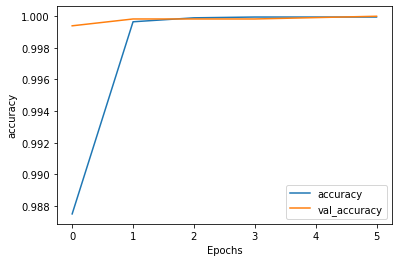

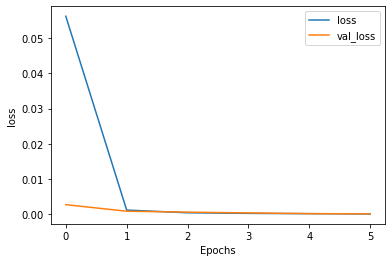

In [8]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Confusion Matrix
Accuracy for 2894 Test Data =  100.0
Accuracy for 5788 Test Data =  100.0
Accuracy for 8682 Test Data =  100.0
Accuracy for 11576 Test Data =  100.0


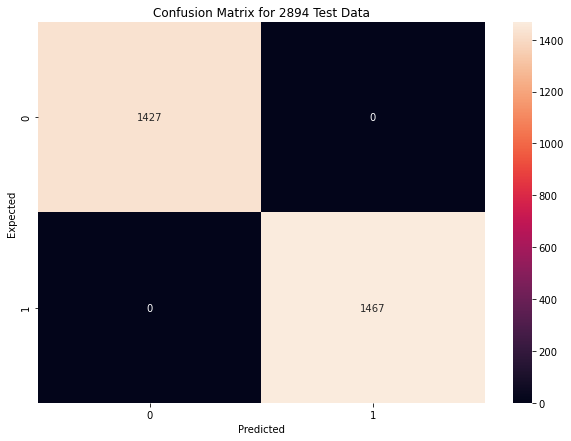

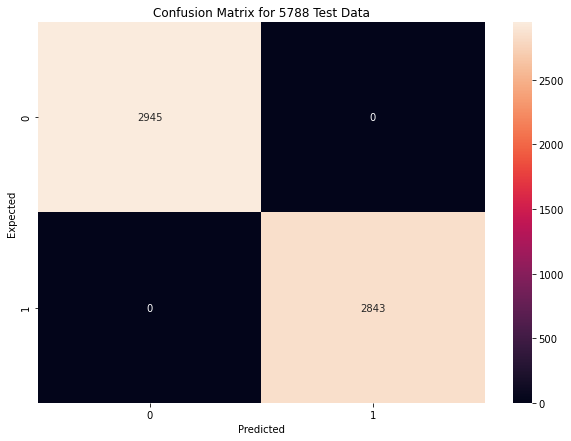

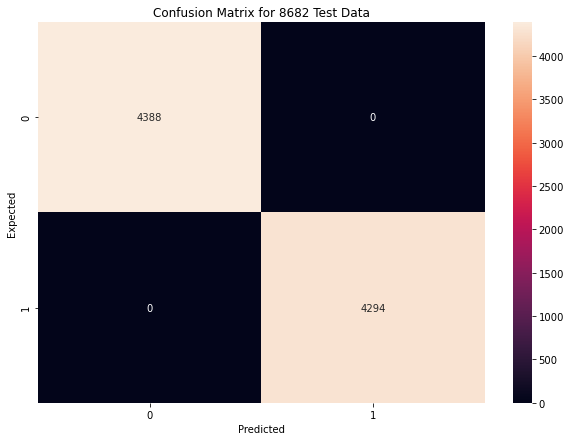

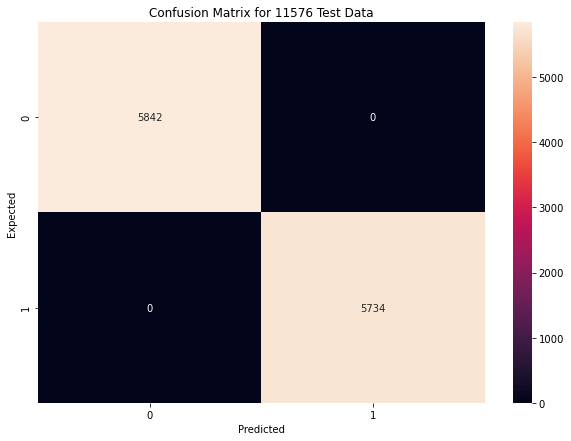

In [9]:
import seaborn
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)
y_predicted_labels = y_predicted > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  cm = tf.math.confusion_matrix(labels=validation_labels[0:total],predictions=y_predicted_labels[0:total])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

In [10]:
model.save('model/text_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/text_model.h5 /content/text_model
print("Model converted to JSON successfully")

Saved the model successfully
zsh:1: command not found: apt-get
created virtual environment CPython3.9.7.final.0-64 in 288ms
  creator CPython3Posix(dest=/home/sahilarora/SensitiveContentFiltering/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/sahilarora/.local/share/virtualenv)
    added seed packages: pip==21.2.4, setuptools==58.0.4, wheel==0.37.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
Traceback (most recent call last):
  File "/home/sahilarora/anaconda3/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/home/sahilarora/anaconda3/lib/python3.8/site-packages/tensorflowjs/converters/converter.py", line 813, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/home/sahilarora/anaconda3/lib/python3.8/site-packages/tensorflowjs/converters/converter.py", line 817, in mai

In [11]:
sentence = ["My credit card no is 124345346", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  print(predictions[i][0])
  if predictions[i][0]>0.5:
    print("Sensitive - "+ sentence[i])
  else:
    print("Non-Sensitive - " + sentence[i] )

0.9569764
Sensitive - My credit card no is 124345346
0.00083112717
Non-Sensitive - game of thrones season finale showing this sunday night
